In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/titanic/train.csv
/kaggle/input/titanic/test.csv
/kaggle/input/titanic/gender_submission.csv


In [2]:

# Utils
# ==============================================================================
import warnings

# Plot
# ==============================================================================
import seaborn as sns
import matplotlib.pyplot as plt

# Data Preprocessing
# ==============================================================================
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer


## Model
# ==============================================================================
from sklearn.model_selection import train_test_split, ParameterGrid

from sklearn.ensemble import RandomForestClassifier

# Metrics
# ==============================================================================
from sklearn.metrics import accuracy_score

# **Info**
---

**@By**: Steven Bernal

**@Nickname**: Kaiziferr

**@Git**: https://github.com/Kaiziferr

# **Nota**
---

### **The interpretation and conclusions for each cell are presented immediately below it. ⚠️** 
### Problem type: Binary classification (0 = Did not survive, 1 = Survived)

# **Objectives**
---

- The goal of the Titanic survival competition on Kaggle is to predict whether a passenger survived the sinking of the Titanic in 1912 using a dataset containing information about each passenger.
- Construir un modelo que pueda estimar con precisión la probabilidad de supervivencia de cada pasajero.

# **Data dictionary**
---

**Data**: The data used comes from the Kaggle competition Titanic: Machine Learning from Disaster.

**Path**: https://www.kaggle.com/competitions/titanic

- `PassengerId` (Integer): Unique ID for each passenger
- `Survived` (Integer, Target): Survival status (0 = No, 1 = Yes)
- `Pclass` (Integer): Ticket class (1 = 1st, 2 = 2nd, 3 = 3rd)
- `Name` (String): Full name of the passenger
- `Sex` (String): Sex of the passenger
- `Age` (Float): Age in years
- `SibSp` (Integer): Number of siblings/spouses aboard
- `Parch` (Integer): Number of parents/children aboard
- `Ticket` (String): Ticket number
- `Fare` (Float): Passenger fare
- `Cabin` (String): Cabin number
- `Embarked` (String): Port of embarkation (C = Cherbourg, Q = Queenstown, S = Southampton)

# **Metric Justification**
---

Although the dataset is slightly imbalanced and in survival problems it could be more important to reduce false negatives, accuracy was chosen as the main metric since it is a competition requirement and provides a quick overall view of the model's performance.

# **Config**
---

In [3]:
random_seed = 12354
sns.set(style="darkgrid")
pd.set_option('display.float_format', '{:,.5f}'.format)
warnings.filterwarnings('ignore')

paleta = {
    "No": "#E41A1C",
    "Yes": "#4DAF4A"
}

# **Utils**
---

In [4]:
def plot_bar(
    data:pd.DataFrame, 
    paleta:list=None, 
    figsize_x:int=8, 
    figsize_y:int=5,
    fontsize:int=15, 
    **kwards)->None:
    """
      Plot a bar chart with multiple features.

    
      Args:
        data (pd.DataFrame):
            DataFrame containing the data to be used for visualization.

        paleta (list, optional):
            List of colors to be used in the plot.
            If not provided, the default color palette will be used.

        figsize_x (int, optional):
            Width of the figure in inches.
            Default is 8.

        figsize_y (int, optional):
            Height of the figure in inches.
            Default is 5.

        fontsize (int, optional):
            Font size used for titles and labels.
            Default is 15.

        **kwards:
            Additional keyword arguments passed directly to the plotting function.

         
      Returns:
        None
    """
    try:
      v = kwards
      ejeX = v['ejeX']

      fig, ax = plt.subplots(figsize = (figsize_x, figsize_y))
      fig.suptitle(f'Bar Chart {v["title"]}', fontsize=fontsize)
      

      if type(ejeX) == str:
          sns.countplot(x=ejeX, data=data, ax = ax, palette=paleta)
      else:
          ejeX = v['ejeX'][0]
          sns.countplot(x=ejeX, hue=v['ejeX'][1], data=data, ax=ax, palette=paleta)

      ax.set_ylabel(v['ejey'], size = 12)
      ax.set_xlabel(ejeX, size=fontsize-3)
      ax.set_xticklabels(ax.get_xticklabels(), fontsize = fontsize-3)
      for p in ax.patches:
          try:
              height = int(p.get_height())
              height_text = height
              if kwards['p'] == True:
                  percentage = round(height/data.shape[0], 5)
                  height_text = f'{height} ({percentage})'
                  ax.text(p.get_x()+p.get_width()/2., height + 1, height_text, ha="center") 
          except Exception as e:
              print(e)
    except Exception as e:
        print(e)



def model_optimization(
    X:pd.DataFrame,
    y:pd.DataFrame,
    model:object,
    dict_params:dict)->dict:
    """
      Find the best combination of parameters for a random forest
      using the OOB score

      Args:
        X (DataFrame):      training data
        y (DataFrame)       labeled data
        model (object):     random forest regressor o Random forest classification
        dict_params (dict): dictionary with the best parameters

      Returns:
        dict: Best combination of parameters
    """
    try:
      results = {'params': [], 'metric': []}

      for params in dict_params:
        model_oobscore = model(**params)
        model_oobscore.fit(X, y)
        results['params'].append(params)
        results['metric'].append(model_oobscore.oob_score_)

      resultados_scores = pd.DataFrame(results)
      resultados_scores = pd.concat(
          [resultados_scores,
           resultados_scores['params'].apply(pd.Series)], axis=1)
      resultados_scores = resultados_scores.drop(columns = 'params')
      if isinstance(params['oob_score'], bool):
        pass
      else:
        resultados_scores['oob_score'] = resultados_scores['oob_score'].apply(
          lambda x: x.__name__)
      return resultados_scores
    except Exception as e:
      print(e)


def null_percentage_per_feature(data:pd.DataFrame, **kwargs)->None:
    """
      
      Calculate the percentage of null values per feature
      
      Args:
        data (pd.DataFrame):
            DataFrame containing the data to be used for visualization.

        **kwards:
            Additional keyword arguments passed directly to the plotting function.

      Returns:
        None 
    """
    try:
        ticklabels = data.isnull().melt().pipe(
            lambda df: (
                sns.displot(
                    data=df,
                    y='variable',
                    hue='value',
                    multiple='fill',
                    aspect=5
                    ).set(**kwargs)
                )
            )
        p = (data.isnull().sum()/data.shape[0])
        for n, i in zip(p.index, range(p.shape[0])):
            if p[i] > 0:
                ticklabels.ax.text(p[n]+0.015, i+0.2, f'{round(p[n]*100, 2)}%', ha="center", color='w', fontweight='bold')
    except Exception as e:
        print(e)

# **Data**

---


In [5]:
data_train = pd.read_csv('/kaggle/input/titanic/train.csv')
data_test = pd.read_csv('/kaggle/input/titanic/test.csv')
data_submission = pd.read_csv('/kaggle/input/titanic/gender_submission.csv')

# **Eda**
---

In [6]:
data_train.dtypes

PassengerId      int64
Survived         int64
Pclass           int64
Name            object
Sex             object
Age            float64
SibSp            int64
Parch            int64
Ticket          object
Fare           float64
Cabin           object
Embarked        object
dtype: object

In [7]:
data_train = data_train.astype({
    'PassengerId': object,
    'Survived': str
})

The data types of PassengerId and Survived are adjusted to 'object' due to their qualitative nature

In [8]:
data_train['Survived'] = data_train['Survived'].replace({
    "0": "No",
    "1": "Yes"
})

Classes are adjusted according "yes" or "no"

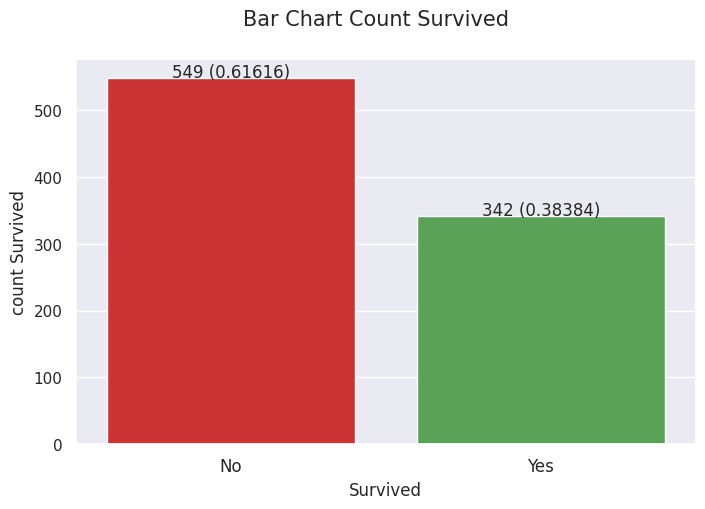

In [9]:
plot_bar(data_train, paleta=paleta, ejeX='Survived',ejey='count Survived',title='Count Survived', p=True)

- There are approximately 62% of passengers who could not survive, compared to 38% who were able to come out alive
- For every 1 passenger who survived, there were approximately 1.6 passengers who died.

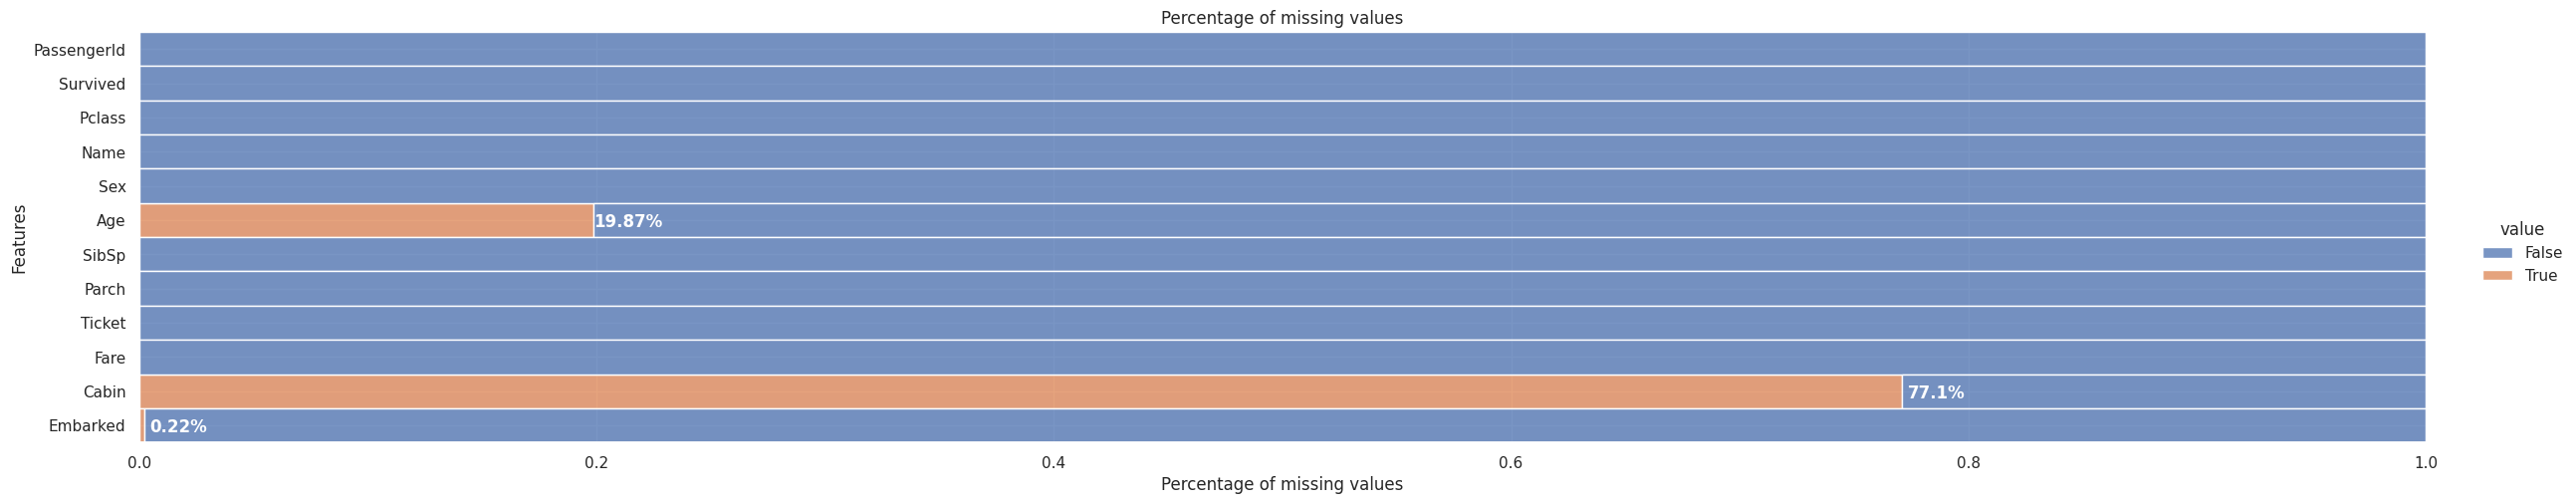

In [10]:
null_percentage_per_feature(data_train, title="Percentage of missing values", xlabel='Percentage of missing values', ylabel='Features')

The variables 'Age', 'Cabin', 'Enbarked" have a null value rate of 19.87%, 77.1% and 0.22% respectively.

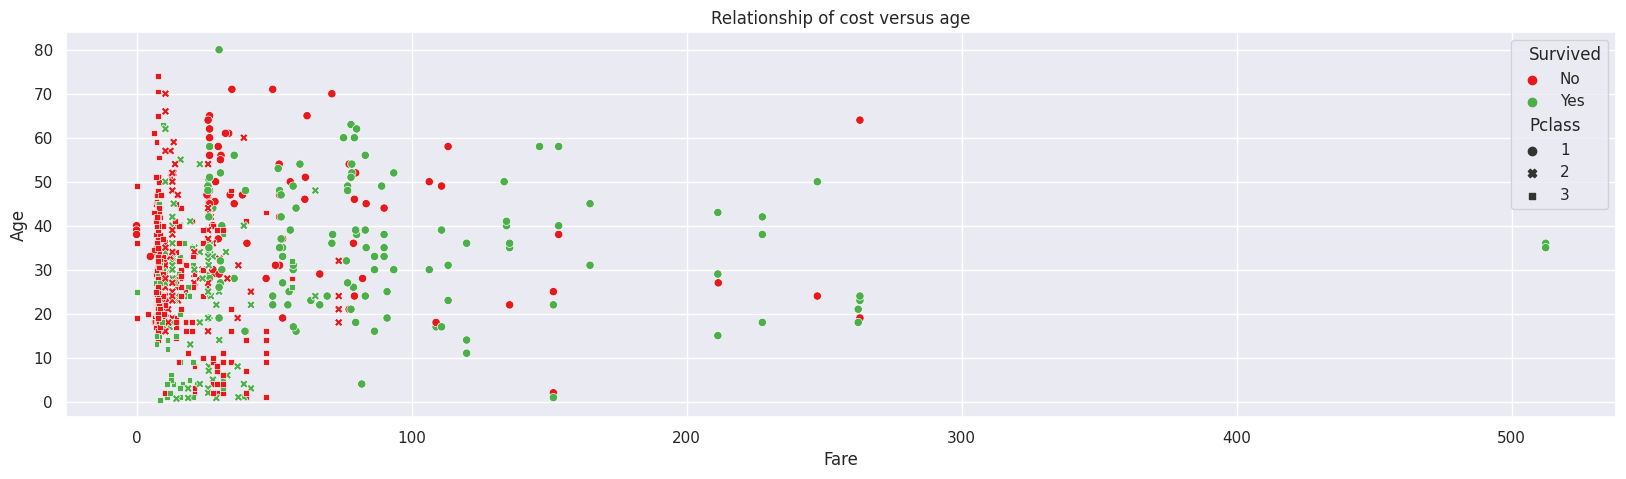

In [11]:
fig, ax = plt.subplots(figsize=(20, 5))
sns.scatterplot(data=data_train, x="Fare", y="Age", hue="Survived", style="Pclass", palette=paleta)
ax.set_title("Relationship of cost versus age")
plt.show()

It is evident that this variable has some inconsistencies, since one can see individuals whose ticket price came at no cost (the value is zero). Moreover, there are cases of individuals in class 1 whose value is similar to class 2 or class 3, which makes no sense, since one would expect the ticket price to vary depending on the class.

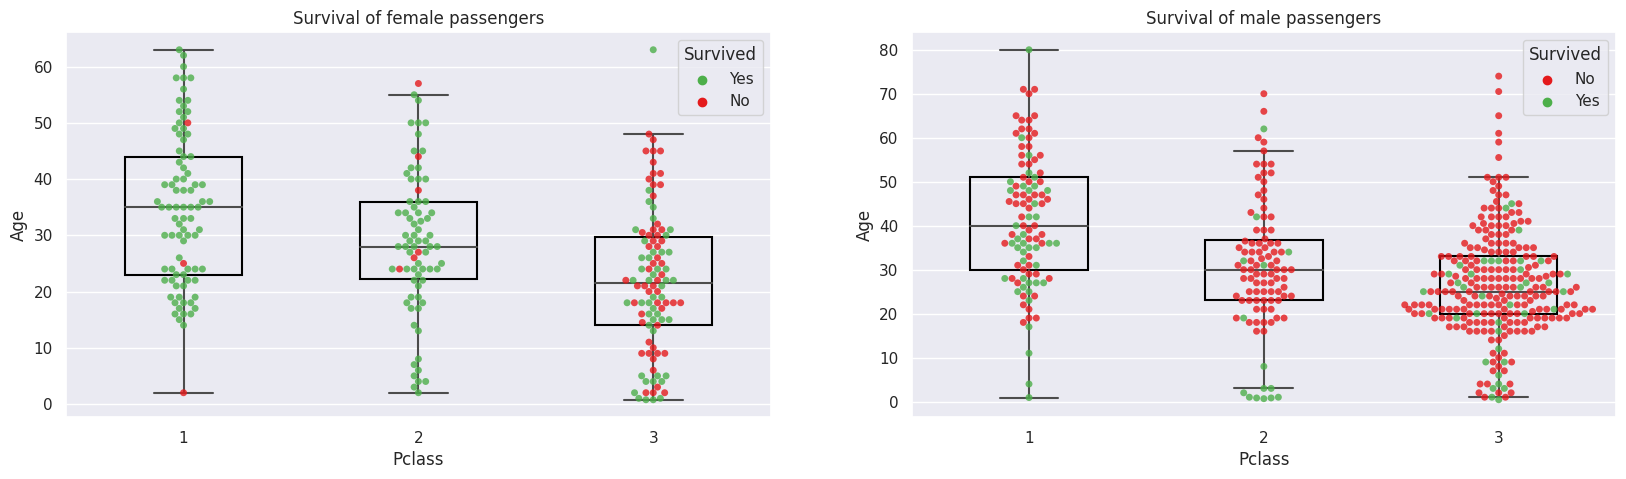

In [12]:
fig, ax = plt.subplots(1, 2, figsize=(20, 5))
gender = ['female', 'male']
for i in range(0,2):
    sns.swarmplot(
        data=data_train[data_train['Sex']==gender[i]], 
        x="Pclass", 
        y="Age", 
        hue="Survived", 
        palette=paleta, 
        alpha=0.8,
    ax=ax[i])
    sns.boxplot(
        data=data_train[data_train['Sex']==gender[i]], 
        x="Pclass", 
        y="Age", 
        saturation=0.0, 
        width=0.5, 
        boxprops=dict(facecolor='none', edgecolor='black'), 
        flierprops=dict(marker=''),
    ax=ax[i])
    ax[i].set_title(f'Survival of {gender[i]} passengers')

**Women**

Women have a higher chance of survival compared to men.
Social class has an impact — if you belong to third class, there is a greater likelihood of dying.
Age does not have a significant impact.

**Men**

Men have a higher chance of dying compared to women.
Social class does not have a significant impact, as there is a high mortality rate in every class, especially in third class.
Age can increase your chance of survival if you are a child under 10 years old.

**Conclusion**

Gender is the variable that has the greatest influence on survival. Although third class is the least favored in terms of survival, women tend to survive more often than men.

In [13]:
data_eda = data_train.copy()
data_eda.loc[data_eda['SibSp'] > 3, 'SibSp'] = 3
data_eda.loc[data_eda['Parch'] > 3, 'Parch'] = 3
data_eda = data_eda.astype(
    {
        'SibSp': str,
        'Parch': str
    }
)
data_eda['SibSp'] = data_eda['SibSp'].replace({"3": "+2"})
data_eda['Parch'] = data_eda['Parch'].replace({"3": "+2"})
data_eda

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,No,3,"Braund, Mr. Owen Harris",male,22.00000,1,0,A/5 21171,7.25000,NaN,S
1,2,Yes,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.00000,1,0,PC 17599,71.28330,C85,C
2,3,Yes,3,"Heikkinen, Miss. Laina",female,26.00000,0,0,STON/O2. 3101282,7.92500,NaN,S
3,4,Yes,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.00000,1,0,113803,53.10000,C123,S
4,5,No,3,"Allen, Mr. William Henry",male,35.00000,0,0,373450,8.05000,NaN,S
...,...,...,...,...,...,...,...,...,...,...,...,...
886,887,No,2,"Montvila, Rev. Juozas",male,27.00000,0,0,211536,13.00000,NaN,S
887,888,Yes,1,"Graham, Miss. Margaret Edith",female,19.00000,0,0,112053,30.00000,B42,S
888,889,No,3,"Johnston, Miss. Catherine Helen ""Carrie""",female,NaN,1,2,W./C. 6607,23.45000,NaN,S
889,890,Yes,1,"Behr, Mr. Karl Howell",male,26.00000,0,0,111369,30.00000,C148,C


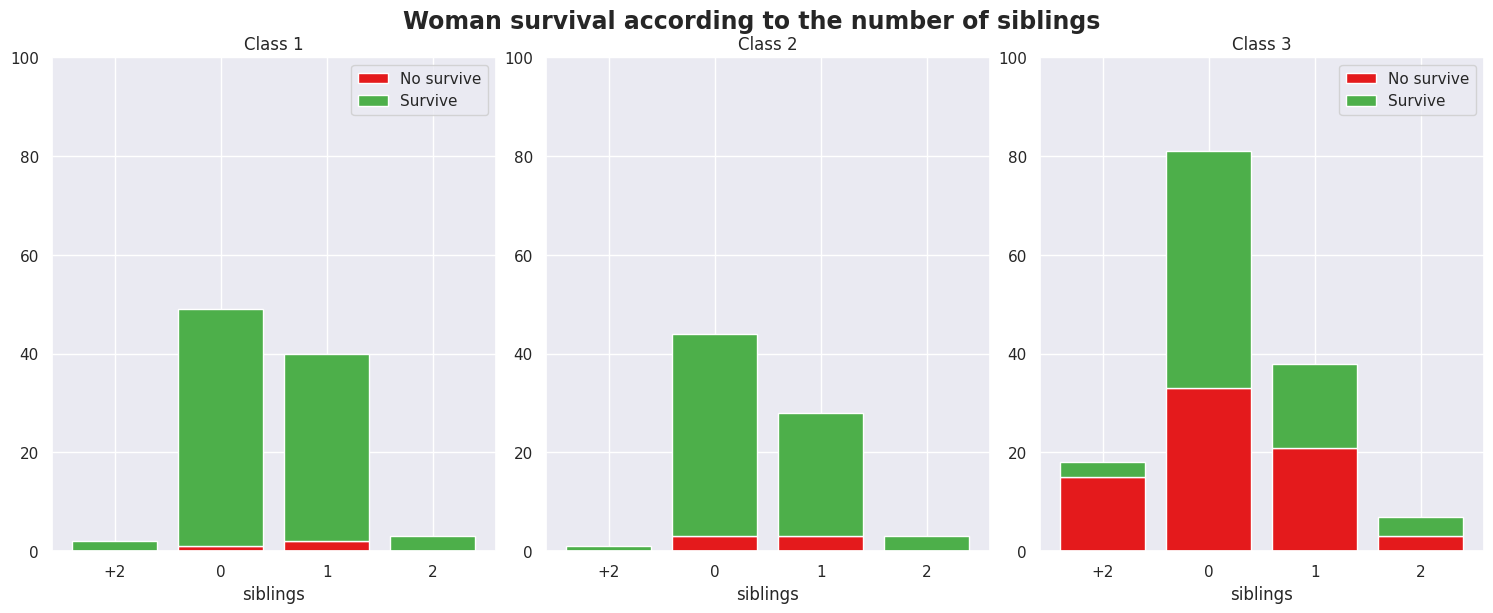

In [14]:
pivot_t = pd.pivot_table(
    data_eda[data_eda['Sex'] == 'female'],
    index=['SibSp'],
    columns=['Pclass', 'Survived'],
    values='PassengerId',
    aggfunc='count',
    fill_value=0
)

pivot_t = pivot_t.reset_index()
pivot_t.columns = [i[1] for i in pivot_t.columns]
bar_width = 0.35
fig, ax = plt.subplots(ncols=3, figsize=(15, 6))
x = range(len(pivot_t.index))
ax = ax.flat


ax[0].bar(x, pivot_t.iloc[:, 1], color = paleta['No'], label="No survive")
ax[0].bar(x, pivot_t.iloc[:, 2], bottom=pivot_t.iloc[:, 1], color = paleta['Yes'], label="Survive")
ax[0].set_xticks(range(0,4),pivot_t[''].values)
ax[0].set_title('Class 1')
ax[0].legend()


ax[1].bar(x, pivot_t.iloc[:, 3], color = paleta['No'],  label="No survive")
ax[1].bar(x, pivot_t.iloc[:, 4], bottom=pivot_t.iloc[:, 3], color = paleta['Yes'], label="Survive")
ax[1].set_xticks(range(0,4),pivot_t[''].values)
ax[1].set_title('Class 2')
ax[0].legend()


ax[2].bar(x, pivot_t.iloc[:, 5], color = paleta['No'],  label="No survive")
ax[2].bar(x, pivot_t.iloc[:, 6], bottom=pivot_t.iloc[:, 5], color = paleta['Yes'], label="Survive")
ax[2].set_xticks(range(0,4),pivot_t[''].values)
ax[2].set_title('Class 3')

fig.tight_layout()
plt.subplots_adjust(top = 0.90)
fig.suptitle('Woman survival according to the number of siblings', fontsize = 17, fontweight = "bold");

for a in ax:
    a.set_xlabel("siblings")
    a.set_ylim(0, 100) 

plt.legend()
plt.show()

Having a number of siblings/spouses aboard in first and second class does not show a significant impact. Only third class seems to be affected; however, it is not easy to determine whether this effect is related to having siblings/spouses aboard or to the class itself.

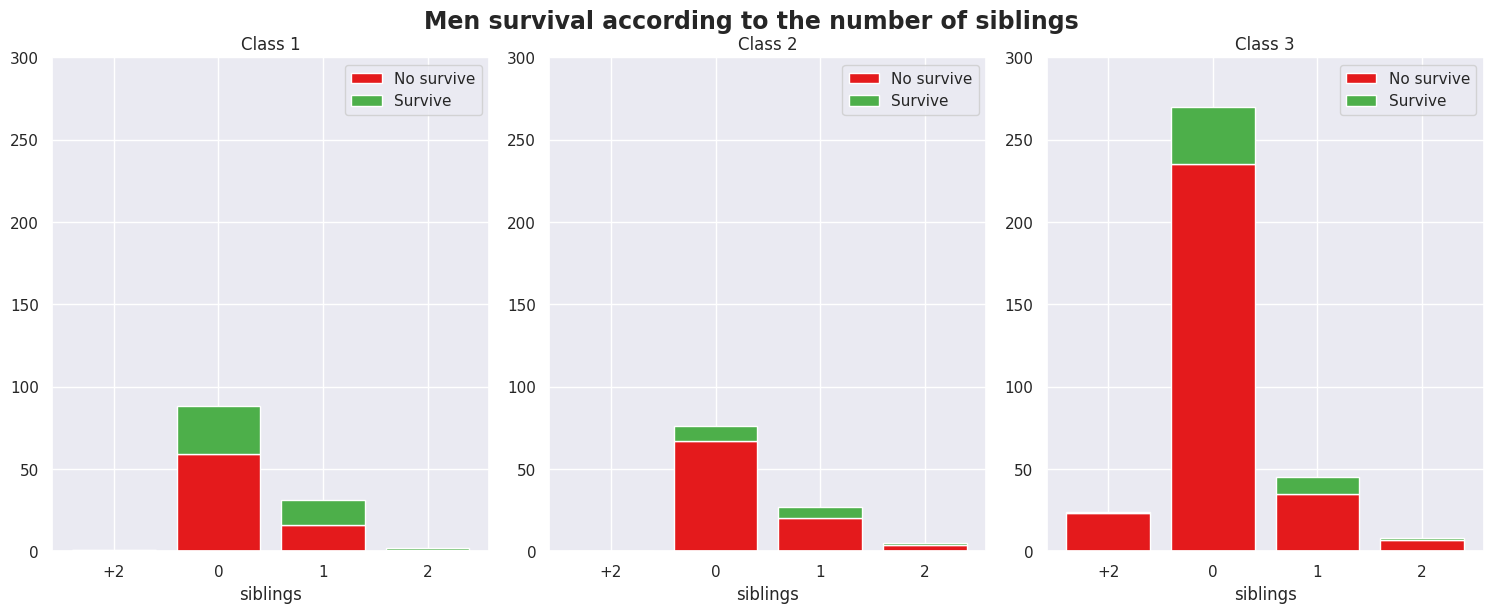

In [15]:
pivot_t = pd.pivot_table(
    data_eda[data_eda['Sex'] == 'male'],
    index=['SibSp'],         
    columns=['Pclass', 'Survived'],
    values='PassengerId',    
    aggfunc='count',         
    fill_value=0             
)

pivot_t = pivot_t.reset_index()
pivot_t.columns = [i[1] for i in pivot_t.columns]
bar_width = 0.35
fig, ax = plt.subplots(ncols=3, figsize=(15, 6))
x = range(len(pivot_t.index))
ax = ax.flat


ax[0].bar(x, pivot_t.iloc[:, 1], color = paleta['No'], label="No survive")
ax[0].bar(x, pivot_t.iloc[:, 2], bottom=pivot_t.iloc[:, 1], color = paleta['Yes'], label="Survive")
ax[0].set_xticks(range(0,4),pivot_t[''].values)
ax[0].set_title('Class 1')
ax[0].legend()


ax[1].bar(x, pivot_t.iloc[:, 3], color = paleta['No'], label="No survive")
ax[1].bar(x, pivot_t.iloc[:, 4], bottom=pivot_t.iloc[:, 3], color = paleta['Yes'], label="Survive")
ax[1].set_xticks(range(0,4),pivot_t[''].values)
ax[1].set_title('Class 2')
ax[1].legend()


ax[2].bar(x, pivot_t.iloc[:, 5], color = paleta['No'], label="No survive")
ax[2].bar(x, pivot_t.iloc[:, 6], bottom=pivot_t.iloc[:, 5], color = paleta['Yes'], label="Survive")
ax[2].set_xticks(range(0,4),pivot_t[''].values)
ax[2].set_title('Class 3')
ax[2].legend()


fig.tight_layout()
plt.subplots_adjust(top = 0.90)
fig.suptitle('Men survival according to the number of siblings', fontsize = 17, fontweight = "bold");

for a in ax:
    a.set_xlabel("siblings")
    a.set_ylim(0, 300) 

Regarding the male gender, the number of siblings/spouses does not have a significant impact on survival, since whether they had them or not, there was a high mortality rate. Considering that most men traveled in third class compared to the other two classes, it is difficult to determine whether the number of siblings/spouses had any influence due to this imbalance, although at first glance, it does not appear to.

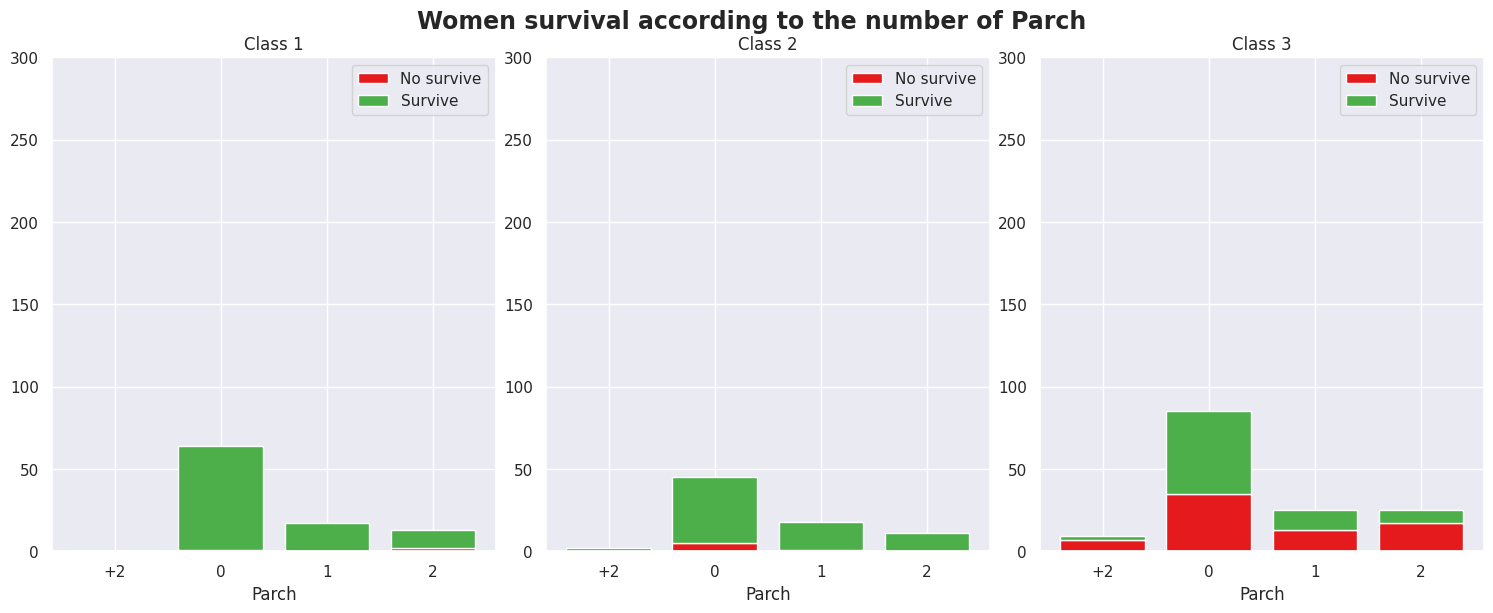

In [16]:
pivot_t = pd.pivot_table(
    data_eda[data_eda['Sex'] == 'female'],
    index=['Parch'],         
    columns=['Pclass', 'Survived'],
    values='PassengerId',    
    aggfunc='count',         
    fill_value=0             
)

pivot_t = pivot_t.reset_index()
pivot_t.columns = [i[1] for i in pivot_t.columns]
bar_width = 0.35
fig, ax = plt.subplots(ncols=3, figsize=(15, 6))
x = range(len(pivot_t.index))
ax = ax.flat


ax[0].bar(x, pivot_t.iloc[:, 1], color = paleta['No'], label="No survive")
ax[0].bar(x, pivot_t.iloc[:, 2], bottom=pivot_t.iloc[:, 1], color = paleta['Yes'], label="Survive")
ax[0].set_xticks(range(0,4),pivot_t[''].values)
ax[0].set_title('Class 1')
ax[0].legend()

ax[1].bar(x, pivot_t.iloc[:, 3], color = paleta['No'], label="No survive")
ax[1].bar(x, pivot_t.iloc[:, 4], bottom=pivot_t.iloc[:, 3], color = paleta['Yes'], label="Survive")
ax[1].set_xticks(range(0,4),pivot_t[''].values)
ax[1].set_title('Class 2')
ax[1].legend()

ax[2].bar(x, pivot_t.iloc[:, 5], color = paleta['No'], label="No survive")
ax[2].bar(x, pivot_t.iloc[:, 6], bottom=pivot_t.iloc[:, 5], color = paleta['Yes'], label="Survive")
ax[2].set_xticks(range(0,4),pivot_t[''].values)
ax[2].set_title('Class 3')
ax[2].legend()

fig.tight_layout()
plt.subplots_adjust(top = 0.90)
fig.suptitle('Women survival according to the number of Parch', fontsize = 17, fontweight = "bold");

for a in ax:
    a.set_xlabel("Parch")
    a.set_ylim(0, 300) 

At first glance, it cannot be determined that having parents/children has any influence on the survival of females in first and second class. However, in third class, having one or more may reduce the chances of survival.

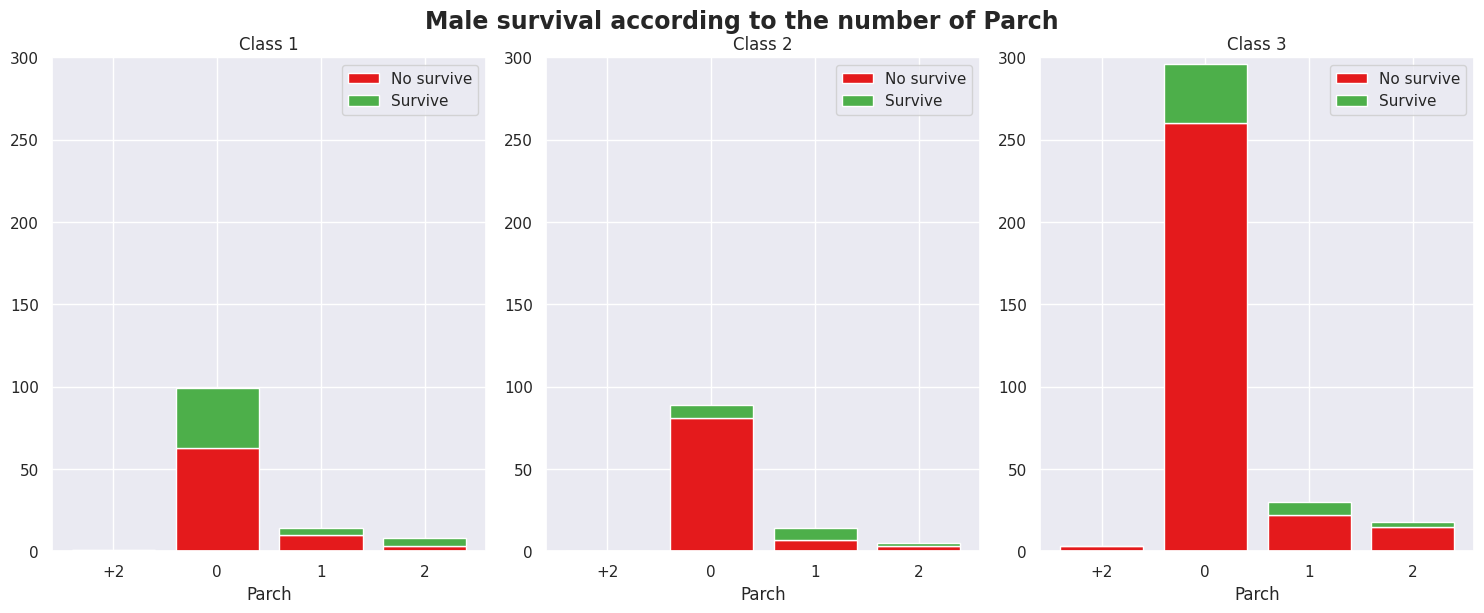

In [17]:
pivot_t = pd.pivot_table(
    data_eda[data_eda['Sex'] == 'male'],
    index=['Parch'],         
    columns=['Pclass', 'Survived'],
    values='PassengerId',    
    aggfunc='count',         
    fill_value=0             
)

pivot_t = pivot_t.reset_index()
pivot_t.columns = [i[1] for i in pivot_t.columns]
bar_width = 0.35
fig, ax = plt.subplots(ncols=3, figsize=(15, 6))
x = range(len(pivot_t.index))
ax = ax.flat


ax[0].bar(x, pivot_t.iloc[:, 1], color = paleta['No'], label="No survive")
ax[0].bar(x, pivot_t.iloc[:, 2], bottom=pivot_t.iloc[:, 1], color = paleta['Yes'], label="Survive")
ax[0].set_xticks(range(0,4),pivot_t[''].values)
ax[0].set_title('Class 1')
ax[0].legend()


ax[1].bar(x, pivot_t.iloc[:, 3], color = paleta['No'], label="No survive")
ax[1].bar(x, pivot_t.iloc[:, 4], bottom=pivot_t.iloc[:, 3], color = paleta['Yes'], label="Survive")
ax[1].set_xticks(range(0,4),pivot_t[''].values)
ax[1].set_title('Class 2')
ax[1].legend()

ax[2].bar(x, pivot_t.iloc[:, 5], color = paleta['No'], label="No survive")
ax[2].bar(x, pivot_t.iloc[:, 6], bottom=pivot_t.iloc[:, 5], color = paleta['Yes'], label="Survive")
ax[2].set_xticks(range(0,4),pivot_t[''].values)
ax[2].set_title('Class 3')
ax[2].legend()

fig.tight_layout()
plt.subplots_adjust(top = 0.90)
fig.suptitle('Male survival according to the number of Parch', fontsize = 17, fontweight = "bold");

for a in ax:
    a.set_xlabel("Parch")
    a.set_ylim(0, 300) 

With respect to men, it is evident that many traveled without parents or children; however, the mortality rate was high.

In [18]:
data_train['Deck'] = data_train['Cabin'].str[0]
data_train['Deck'] = data_train['Deck'].fillna('No Deck')


data_test['Deck'] = data_test['Cabin'].str[0]
data_test['Deck'] = data_test['Deck'].fillna('No Deck')

Information is extracted from the cabin, using the first letter, to determine which cabins are located on the deck.

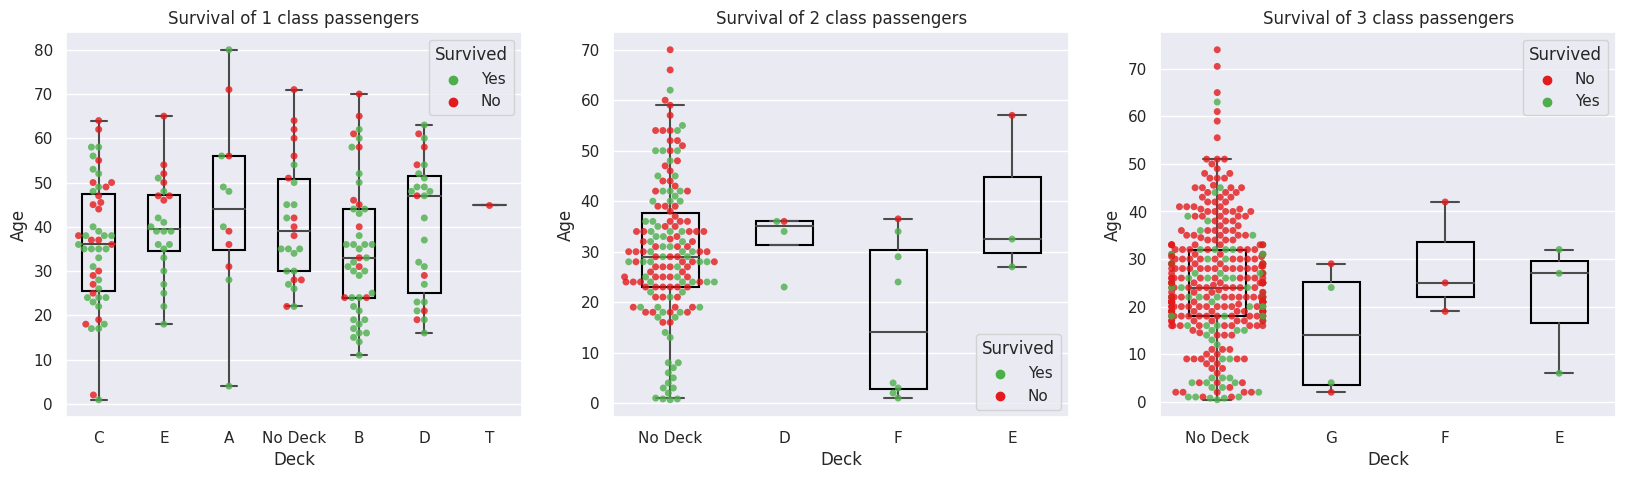

In [19]:
fig, ax = plt.subplots(1, 3, figsize=(20, 5))
pClass = [1, 2, 3]
for i in range(0,3):
    sns.swarmplot(
        data=data_train[data_train['Pclass']==pClass[i]], 
        x="Deck", 
        y="Age", 
        hue="Survived", 
        palette=paleta, 
        alpha=0.8,
    ax=ax[i])
    sns.boxplot(
        data=data_train[data_train['Pclass']==pClass[i]], 
        x="Deck", 
        y="Age", 
        saturation=0.0, 
        width=0.5, 
        boxprops=dict(facecolor='none', edgecolor='black'), 
        flierprops=dict(marker=''),
    ax=ax[i])
    ax[i].set_title(f'Survival of {pClass[i]} class passengers')

It is evident that there is a high likelihood of survival if the person has a cabin, preferably near the deck, which was presumably reserved for the upper classes

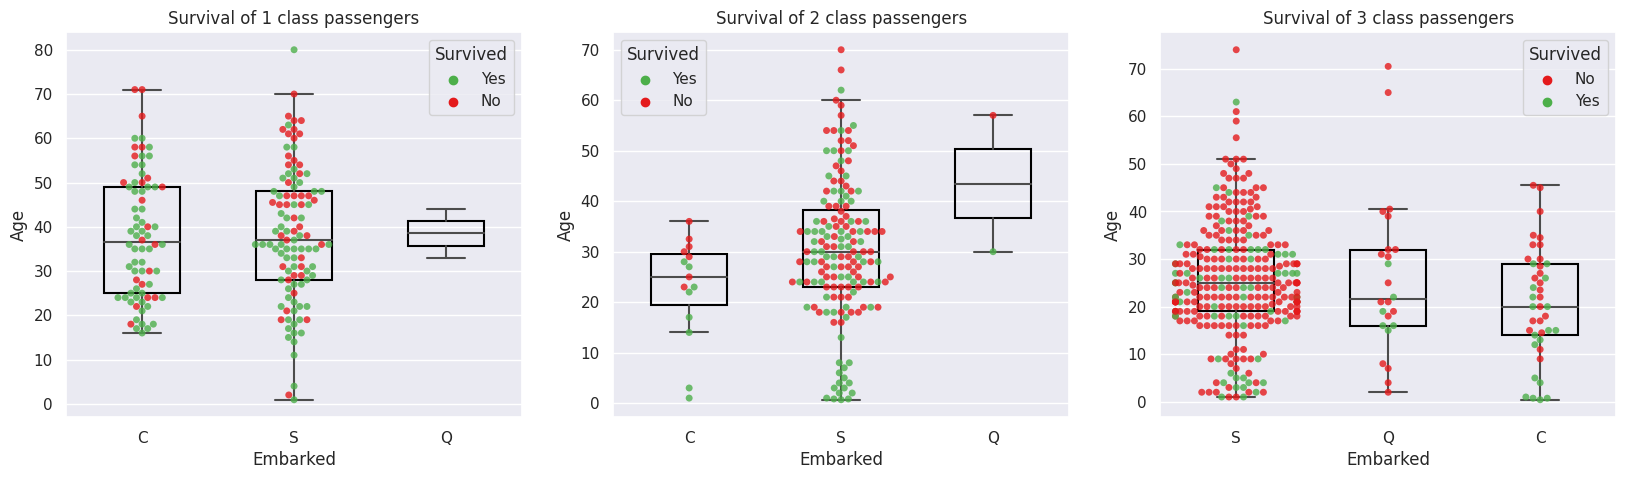

In [20]:
fig, ax = plt.subplots(1, 3, figsize=(20, 5))
pClass = [1, 2, 3]
for i in range(0,3):
    sns.swarmplot(
        data=data_train[data_train['Pclass']==pClass[i]], 
        x="Embarked", 
        y="Age", 
        hue="Survived", 
        palette=paleta, 
        alpha=0.8,
    ax=ax[i])
    sns.boxplot(
        data=data_train[data_train['Pclass']==pClass[i]], 
        x="Embarked", 
        y="Age", 
        saturation=0.0, 
        width=0.5, 
        boxprops=dict(facecolor='none', edgecolor='black'), 
        flierprops=dict(marker=''),
    ax=ax[i])
    ax[i].set_title(f'Survival of {pClass[i]} class passengers')

It is evident that the boarding location may influence survival; however, this is circumstantial evidence that would only apply to the Titanic, according to evidence analysis empirical .

Passengers who embarked at Cherbourg (C) had a higher proportion of first-class passengers and expensive tickets. At Queenstown (Q), most passengers were third-class with fewer resources. Meanwhile, Southampton (S) had a large number of passengers from all classes, mainly second and third class.

In [21]:
data_train['honoric_title'] = data_train['Name'].str.extract(r',\s*([^\.]+)\.')
data_train['honoric_title'].unique()

array(['Mr', 'Mrs', 'Miss', 'Master', 'Don', 'Rev', 'Dr', 'Mme', 'Ms',
       'Major', 'Lady', 'Sir', 'Mlle', 'Col', 'Capt', 'the Countess',
       'Jonkheer'], dtype=object)

In [22]:
data_test['honoric_title'] = data_test['Name'].str.extract(r',\s*([^\.]+)\.')
data_test['honoric_title'].unique()

array(['Mr', 'Mrs', 'Miss', 'Master', 'Ms', 'Col', 'Rev', 'Dr', 'Dona'],
      dtype=object)

The honorific title is extracted in order to determine the age of those passengers whose age is not available

In [23]:
data_train['Survived'] = data_train['Survived'].replace({'No':0, 'Yes':1})

# **Data Split**
---

In [24]:
data_train = data_train.drop(['PassengerId', 'Name', 'Ticket', 'Cabin'], axis = 1)
data_test = data_test.drop(['PassengerId', 'Name', 'Ticket', 'Cabin'], axis = 1)

The columns 'PassengerId', 'Name', 'Ticket', and 'Cabin' are removed because they do not provide relevant information for analysis or prediction

In [25]:
X = data_train.drop(['Survived'], axis=1)
y = data_train['Survived']

In [26]:
X_train, X_test, y_train, y_test = train_test_split(
    X,
    y,
    train_size = 0.85,
    random_state = random_seed,
    stratify=y
)

# **Preprocessing**
---

In [27]:
X_train.groupby(['Pclass', 'Embarked'])['Fare'].mean()

Pclass  Embarked
1       C          106.37369
        Q           90.00000
        S           72.10529
2       C           25.11250
        Q           12.35000
        S           20.58368
3       C           10.88783
        Q           11.62756
        S           15.02627
Name: Fare, dtype: float64

In [28]:
X_train.loc[X_train['Embarked'].isnull(), 'Embarked'] = 'S'

Missing values were identified in the Embarked column, so the average ticket price (Fare) was analyzed according to passenger class (Pclass) and port of embarkation (Embarked).

In [29]:
X_train[~X_train['Age'].isnull()].groupby('honoric_title')['Age'].median()

honoric_title
Capt           70.00000
Col            58.00000
Don            40.00000
Dr             44.00000
Jonkheer       38.00000
Major          48.50000
Master          4.00000
Miss           21.00000
Mlle           24.00000
Mme            24.00000
Mr             29.00000
Mrs            35.00000
Ms             28.00000
Rev            46.50000
the Countess   33.00000
Name: Age, dtype: float64

In [30]:
X_train.groupby('honoric_title')['Age'].mean().to_dict()

{'Capt': 70.0,
 'Col': 58.0,
 'Don': 40.0,
 'Dr': 40.4,
 'Jonkheer': 38.0,
 'Major': 48.5,
 'Master': 4.813999999999999,
 'Miss': 21.456967213114755,
 'Mlle': 24.0,
 'Mme': 24.0,
 'Mr': 32.206647398843934,
 'Mrs': 35.89887640449438,
 'Ms': 28.0,
 'Rev': 43.166666666666664,
 'the Countess': 33.0}

In [31]:
null_age = X_train.groupby('honoric_title')['Age'].median().apply(np.floor).to_dict()

X_train['Age'] = X_train.apply(
    lambda x: null_age[x['honoric_title']] if pd.isnull(x['Age']) else x['Age'],
    axis=1
)


X_test['Age'] = X_test.apply(
    lambda x: null_age[x['honoric_title']] if pd.isnull(x['Age']) else x['Age'],
    axis=1
)


data_test['Age'] = data_test.apply(
    lambda x: null_age[x['honoric_title']] if pd.isnull(x['Age']) else x['Age'],
    axis=1
)

To impute the missing values in the Age column, the median age of passengers was calculated based on the honorific title in their Name for those records where age was available, and this value was used to fill in the missing data.

In [32]:
X_train = X_train.drop(['honoric_title'], axis=1)
X_test = X_test.drop(['honoric_title'], axis=1)
data_test = data_test.drop(['honoric_title'], axis=1)

In [33]:
numeric_cols = X_train.select_dtypes(include=['float64', 'int64']).columns.to_list()
cat_cols = X_train.select_dtypes(include=['object', 'category']).columns.to_list()

preprocessor = ColumnTransformer(
    transformers = [
        ('onehotencoder', OneHotEncoder(drop='first'), cat_cols)
    ],
    remainder="passthrough",
)
preprocessor

ColumnTransformer(remainder='passthrough',
                  transformers=[('onehotencoder', OneHotEncoder(drop='first'),
                                 ['Sex', 'Embarked', 'Deck'])])

In [34]:
X_train_prep = preprocessor.fit_transform(X_train)
X_test_prep  = preprocessor.transform(X_test)

# Model
---

In [35]:
dict_params = ParameterGrid(
    {
        "n_estimators": [100, 200, 300],
        "max_depth":  [None, 5, 8, 12],
        "min_samples_split": [2, 5, 10],
        "min_samples_leaf": [1, 2, 4],
        "max_features": ["sqrt", "log2"],
        "criterion": ["gini", "entropy", "log_loss"],
        'oob_score': [True],
        "n_jobs": [-1],
        "random_state": [random_seed]
    }
)

In [36]:
resultados_scores = model_optimization(X_train_prep, y_train, RandomForestClassifier, dict_params)

In [37]:
resultados_scoresT = resultados_scores[
    resultados_scores['oob_score'] == True].sort_values(
        'metric', ascending=False)
resultados_scoresT

,metric,criterion,max_depth,max_features,min_samples_leaf,min_samples_split,n_estimators,n_jobs,oob_score,random_state
347,0.84016,entropy,8.00000,sqrt,4,5,300,-1,True,12354
344,0.84016,entropy,8.00000,sqrt,4,2,300,-1,True,12354
563,0.84016,log_loss,8.00000,sqrt,4,5,300,-1,True,12354
374,0.84016,entropy,8.00000,log2,4,5,300,-1,True,12354
371,0.84016,entropy,8.00000,log2,4,2,300,-1,True,12354
...,...,...,...,...,...,...,...,...,...,...
1,0.80713,gini,NaN,sqrt,1,2,200,-1,True,12354
28,0.80713,gini,NaN,log2,1,2,200,-1,True,12354
29,0.80713,gini,NaN,log2,1,2,300,-1,True,12354
27,0.80185,gini,NaN,log2,1,2,100,-1,True,12354


The Random Forest model was implemented due to its versatility and robustness for classification tasks. This model can handle both numerical and categorical variables, manage missing data, and reduce the risk of overfitting by combining multiple decision trees. These characteristics make it well-suited for predicting the likelihood of passenger survival in the Titanic tragedy. To determine the optimal hyperparameter configuration for the model, the Out-of-Bag (OOB) score was used as the evaluation metric, taking advantage of its ability to internally estimate model accuracy without the need for a separate validation set.

In [38]:
resultados_scoresT.iloc[0, 1:].to_dict()

best_params = {
  **resultados_scoresT.iloc[0, 1:].to_dict(),
  'max_depth': 8,
  'oob_score': True}
best_params

model = RandomForestClassifier(
    **best_params
)

model.fit(X_train_prep, y_train)

RandomForestClassifier(criterion='entropy', max_depth=8, min_samples_leaf=4,
                       min_samples_split=5, n_estimators=300, n_jobs=-1,
                       oob_score=True, random_state=12354)

In [39]:
y_pred_train = model.predict(X_train_prep)
score = accuracy_score(y_train, y_pred_train)
print(f'Accuracy Data Train: {score}')
y_pred_test = model.predict(X_test_prep)
score = accuracy_score(y_test, y_pred_test)
print(f'Accuracy Data Test: {score}')

Accuracy Data Train: 0.8705416116248349
Accuracy Data Test: 0.8283582089552238


The model achieves an approximate 83% accuracy, indicating its ability to correctly predict passenger survival in the Titanic accident.

# **Score**
---

In [40]:
data_test.isnull().sum()

Pclass      0
Sex         0
Age         0
SibSp       0
Parch       0
Fare        1
Embarked    0
Deck        0
dtype: int64

In [41]:
data_test['Fare'] = data_test['Fare'].fillna(data_test['Fare'].mean()) 

In [42]:
X_validation = preprocessor.transform(data_test)
y_predict = model.predict(X_validation)

In [43]:
accuracy_score(data_submission['Survived'],y_predict)

0.8732057416267942

In [44]:
data_submission['Survived'] = y_predict

In [45]:
data_submission.to_csv('gender_submission.csv', index=False)

In [46]:
data_submission

,PassengerId,Survived
0,892,0
1,893,0
2,894,0
3,895,0
4,896,0
...,...,...
413,1305,0
414,1306,1
415,1307,0
416,1308,0


# **Info**
---

**@By**: Steven Bernal

**@Nickname**: Kaiziferr

**@Git**: https://github.com/Kaiziferr